## Image segmentation with CamVid

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo, dont forget to add a ! before git :

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [4]:
! git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 35.79 MiB/s, done.
Resolving deltas: 100% (81/81), done.


Path is just the working directory where temporary files/models will be saved.





In [0]:
path = Path('/content/SegNet-Tutorial/CamVid')

In [13]:
path.ls()

[PosixPath('/content/SegNet-Tutorial/CamVid/testannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train')]

## Dataset Exploration

* get_image_files(c:PathOrStr, check_ext:bool=True, recurse=False) → FilePathList

* Return list of files that are images.

* **check_ext** will filter to image_extensions.

In [14]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08101.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08045.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08003.png')]

* **valannot**:annotated valid images

In [15]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08101.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08045.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08003.png')]

**open(fn)**
* Open image in fn, subclass and overwrite for custom behavior.

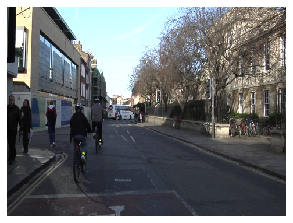

In [21]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

* **get_y_fn(x):** returns pathname of annotated image of corresponding parent image

* codes refers to the different classes of pixels present in the image 

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

**To easily open a mask, the function open_mask plays the same role as open_image:**

* open_mask(fn:PathOrStr, div=False, convert_mode='L', after_open:Callable=None) → ImageSegment

* Return ***ImageSegment*** object created from mask in file fn. If div, divides pixel values by 255.

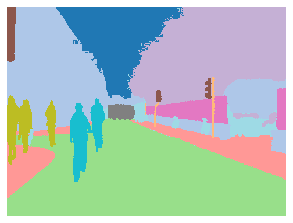

In [24]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=3)

* Each image is converted to arrays


In [26]:
src_size = np.array(mask.shape[1:])
src_size

array([360, 480])

* Pixels being assinged one of several classes given in codes array

In [29]:
mask.data

tensor([[[6, 6, 6,  ..., 5, 5, 5],
         [6, 6, 6,  ..., 5, 5, 5],
         [6, 6, 6,  ..., 5, 5, 5],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]])

## Preparing Dataset to feed into Model

In [0]:
bs,size = 8,src_size//2

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

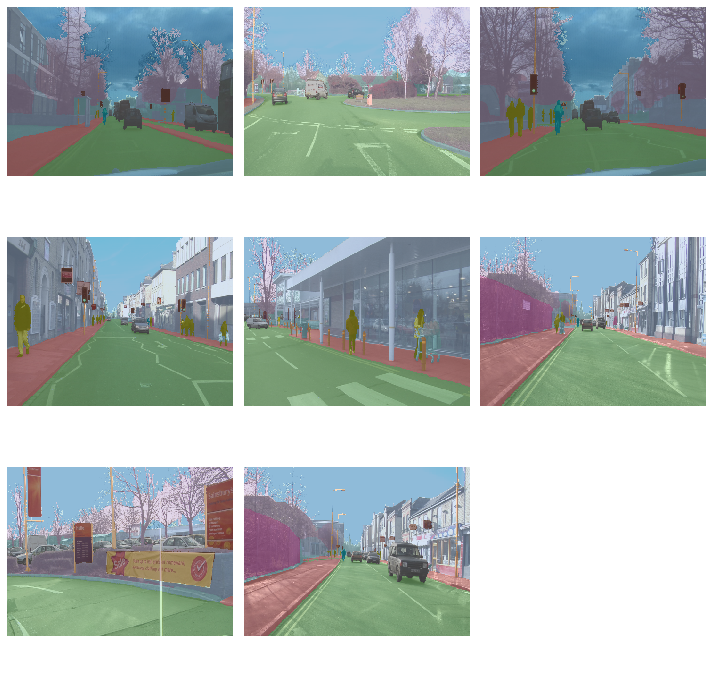

In [40]:
data.show_batch(3,3, figsize=(10,10))

## Model

In [0]:
codesdict = {v:k for k,v in enumerate(codes)}
void_code = codesdict['Void']

In [59]:
codesdict

{'Building': 1,
 'Car': 8,
 'Cyclist': 10,
 'Fence': 7,
 'Pedestrian': 9,
 'Pole': 2,
 'Road': 3,
 'Sidewalk': 4,
 'Sign': 6,
 'Sky': 0,
 'Tree': 5,
 'Void': 11}

In [0]:
def accuracy(input, target):
    target = target.squeeze(1)
    mask = (target != void_code)
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=accuracy
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

In [98]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


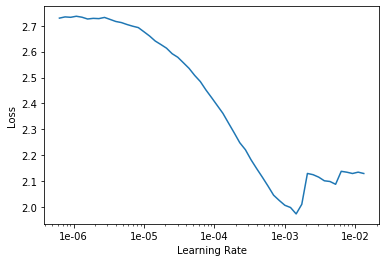

In [56]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-3

In [74]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,1.201346,0.953487,0.735203,00:46
1,0.811727,0.554793,0.847641,00:43
2,0.644629,0.511513,0.863331,00:45
3,0.544391,0.536246,0.849497,00:44
4,0.504174,0.576024,0.849845,00:44
5,0.482750,0.476559,0.858795,00:44
6,0.443613,0.327062,0.899452,00:44
7,0.458945,0.645039,0.865986,00:44
8,0.472432,0.381996,0.878124,00:44
9,0.398179,0.326206,0.888560,00:44


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr)

In [79]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.334128,0.314263,0.890525,00:46
1,0.318846,0.272902,0.916616,00:46
2,0.305929,0.288122,0.908058,00:46
3,0.294600,0.300300,0.908433,00:46
4,0.304579,0.333009,0.907674,00:46
5,0.326424,0.416362,0.883326,00:46
6,0.304677,0.274263,0.918964,00:46
7,0.302945,0.314989,0.917272,00:46
8,0.291216,0.331997,0.901204,00:45
9,0.289467,0.275446,0.927799,00:45


In [80]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.198229,0.233961,0.934474,00:45
1,0.195746,0.239935,0.933362,00:45
2,0.196189,0.253512,0.929191,00:46
3,0.197468,0.242138,0.931637,00:45
4,0.212937,0.270691,0.926359,00:46
5,0.242061,0.336243,0.913995,00:45
6,0.249530,0.251278,0.927916,00:45
7,0.239575,0.229215,0.935956,00:45
8,0.226419,0.216338,0.943720,00:45
9,0.200932,0.221075,0.940751,00:45


In [0]:
learn.save('stage-2');

## 

In [82]:
learn=None
gc.collect()

68

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=8

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


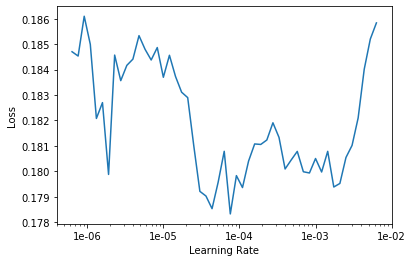

In [86]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [88]:
learn.fit_one_cycle(9, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.178540,0.222627,0.938797,00:41
1,0.177791,0.218450,0.939154,00:42
2,0.174370,0.214052,0.943104,00:42
3,0.173930,0.209487,0.942296,00:43
4,0.173152,0.232371,0.941011,00:43
5,0.173916,0.243029,0.930441,00:43
6,0.172647,0.247546,0.936921,00:43
7,0.169150,0.232498,0.938497,00:43
8,0.167762,0.219078,0.943019,00:43
9,0.157474,0.219948,0.941813,00:43


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [93]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,0.147398,0.222005,0.941060,00:46
1,0.148391,0.223129,0.941256,00:45
2,0.146786,0.232392,0.940916,00:45
3,0.146060,0.227518,0.941346,00:45
4,0.144740,0.236861,0.939922,00:45
5,0.143870,0.237359,0.939042,00:45
6,0.143237,0.227831,0.941370,00:45
7,0.142109,0.232288,0.940486,00:45
8,0.140843,0.233416,0.940481,00:45
9,0.141186,0.240280,0.939576,00:45


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

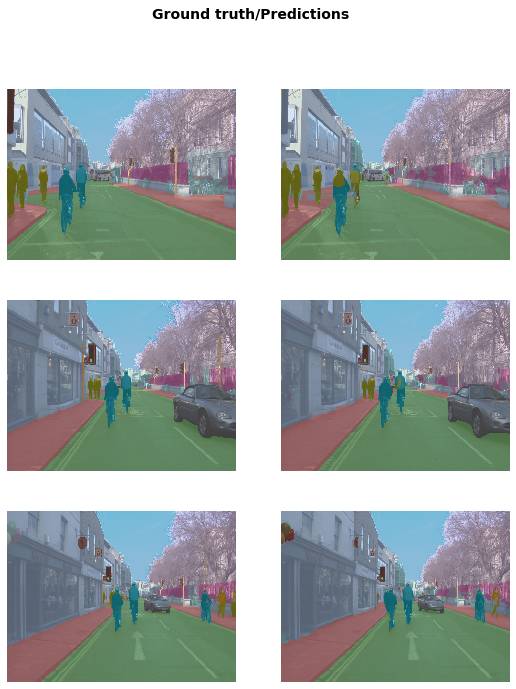

In [96]:
learn.show_results(rows=3, figsize=(9,11))

In [99]:
11+1

12